# Credit Risk Modelling: Project
Antoni Ballaun, Laura Hoang, Jędrzej Joniec, Piotr Zambrzycki

## 03. Data preparation: data binning and feature selection
The aim for this part is to calculate the Information Value for each variable, and based on this (and some other methods) make feature selection for the models.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

This part will be done on cleaned data - after `01_missing_data.ipynb`.

The data frame is now free of missing values, all date-format variables have been converted into integer form (number of days), and boolean columns have been converted to binary values.

In [43]:
df = pd.read_csv('filled_missings_df.csv',index_col=0)

In [44]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,Term,LoanStatus,BorrowerAPR,BorrowerRate,LenderYield,ListingCategory (numeric),BorrowerState,...,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Defaulted
0,1021339766868145413AB3B,193129,13751.0,36,Completed,0.16516,0.1580,0.1380,0,CO,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258,0
1,10273602499503308B223C1,1209647,16128.0,36,Current,0.12016,0.0920,0.0820,2,CO,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1,0
2,0EE9337825851032864889A,81716,13518.0,36,Completed,0.28269,0.2750,0.2400,0,GA,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41,0
3,0EF5356002482715299901A,658116,15635.0,36,Current,0.12528,0.0974,0.0874,16,GA,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158,0
4,0F023589499656230C5E3E2,909464,15962.0,36,Current,0.24614,0.2085,0.1985,2,MN,...,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20,0


In [45]:
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'Term',
       'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'ListingCategory (numeric)', 'BorrowerState', 'EmploymentStatus',
       'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'AvailableBankcardCredit', 'TotalTrades',
       'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months',
       'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable',
       'StatedMonthlyIncome', 'LoanKey', 'LoanCurrentDaysDe

Column descriptions can be found here: https://docs.google.com/spreadsheets/d/1lTxLIwJU8rwVn1gsin3Q1w5btT1R1X-7oqGn5XDz-Xs/edit?usp=sharing

### Drop columns with information given after the client receives a loan
All these columns should be droppedd if we assume that we are making a model focused on scoring clients before giving them a loan:

In [46]:
cols_to_drop = ['ListingKey', 'ListingNumber', 'LoanStatus', 'LoanKey', 'LoanCurrentDaysDelinquent', 'LoanMonthsSinceOrigination', 'LoanNumber',
                'MemberKey', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
                'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'LoanOriginationDate', 'LoanOriginationQuarter',
                'FirstRecordedCreditLine', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'ListingCreationDate', 'DateCreditPulled']

In [47]:
df = df.drop(columns=cols_to_drop)

### Finding the rest of columns with no meaning

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114805 entries, 0 to 114804
Data columns (total 39 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Term                                114805 non-null  int64  
 1   BorrowerAPR                         114805 non-null  float64
 2   BorrowerRate                        114805 non-null  float64
 3   LenderYield                         114805 non-null  float64
 4   ListingCategory (numeric)           114805 non-null  int64  
 5   BorrowerState                       114805 non-null  object 
 6   EmploymentStatus                    114805 non-null  object 
 7   EmploymentStatusDuration            114805 non-null  float64
 8   IsBorrowerHomeowner                 114805 non-null  int64  
 9   CurrentlyInGroup                    114805 non-null  int64  
 10  OpenCreditLines                     114805 non-null  float64
 11  TotalCreditLinespast7years     

### Bins for feature selection and LogReg

In [49]:
# Binning continous variables
continous_columns = ['DebtToIncomeRatio', 'LenderYield' ]

### Splitting the data: trand and test
First train test split, only fit on train and transform test based on bin edges

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=101)

### Binning with optbin
The aim for this part is to calculate Weight of Evidence and Information Value for each variable.

To read more about WOE and IV read: https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#what_is_weight_of_evidence

In [ ]:
from optbinning import OptimalBinning

y_train = train_df["Defaulted"]
X_train = train_df.drop(columns=["Defaulted"])
X_test = test_df.copy()

binning_transformers = {}
X_train_binned = pd.DataFrame()
X_test_binned = pd.DataFrame()
X_train_binned_woe = pd.DataFrame()
X_test_binned_woe = pd.DataFrame()
all_woe_rows = []
iv_scores = {}

def is_binary(series):
    return set(series.dropna().unique()) <= {0, 1}


for column in X_train.columns:
    # Define variable type
    if is_binary(X_train[column]):
        dtype = "categorical"
    elif pd.api.types.is_numeric_dtype(X_train[column]):
        dtype = "numerical"
    else:
        dtype = "categorical"

    # Fit binning
    optb = OptimalBinning(name=column, dtype=dtype, solver="cp", max_n_bins=3)
    optb.fit(X_train[column], y_train)
    binning_transformers[column] = optb

    # Transform to WOE and bins
    X_train_binned_woe[column] = -optb.transform(X_train[column], metric="woe")
    X_test_binned_woe[column] = -optb.transform(X_test[column], metric="woe")
    X_train_binned[column] = optb.transform(X_train[column], metric="bins")
    X_test_binned[column] = optb.transform(X_test[column], metric="bins")

    # Build binning table and extract WOE info
    binning_table_df = optb.binning_table.build()
    iv_scores[column] = float(optb.binning_table.iv)

    # Add variable name and IV to each row, then store
    binning_table_df["Variable"] = column
    binning_table_df["IV"] = iv_scores[column]
    all_woe_rows.append(binning_table_df[["Variable", "Bin", "Count", "Event rate", "WoE", "IV"]])


all_woe_combined = pd.concat(all_woe_rows, ignore_index=True)

all_woe_combined.to_excel("woe_all_variables.xlsx", index=False)

print(all_woe_combined.head())

  Variable            Bin  Count  Event rate       WoE        IV
0     Term  (-inf, 48.00)  71659    0.174479  -0.19728  0.217872
1     Term   [48.00, inf)  20185    0.053356  1.124438  0.217872
2     Term        Special      0    0.000000       0.0  0.217872
3     Term        Missing      0    0.000000       0.0  0.217872
4     Term                 91844    0.147859            0.217872


### Feature selection based on Information Value

In [53]:
iv_scores

{'Term': 0.21787231563493004,
 'BorrowerAPR': 0.2702199551901524,
 'BorrowerRate': 0.3814228828411286,
 'LenderYield': 0.370926816899894,
 'ListingCategory (numeric)': 0.4905577648612991,
 'BorrowerState': 0.057466611966100714,
 'EmploymentStatus': 0.7221310333251305,
 'EmploymentStatusDuration': 0.20193232382262077,
 'IsBorrowerHomeowner': 0.015376850894377861,
 'CurrentlyInGroup': 0.2876375490102512,
 'OpenCreditLines': 0.23307609382985228,
 'TotalCreditLinespast7years': 0.0621598421802579,
 'OpenRevolvingAccounts': 0.22998115905344196,
 'OpenRevolvingMonthlyPayment': 0.2788728145059118,
 'InquiriesLast6Months': 0.39054080235822125,
 'TotalInquiries': 0.3649246619566935,
 'CurrentDelinquencies': 0.28100265996741525,
 'AmountDelinquent': 0.07296320689888242,
 'DelinquenciesLast7Years': 0.08675256993848861,
 'PublicRecordsLast10Years': 0.019378897017317903,
 'PublicRecordsLast12Months': 0.0,
 'RevolvingCreditBalance': 0.15062863672973806,
 'BankcardUtilization': 0.10897630600196344,
 '

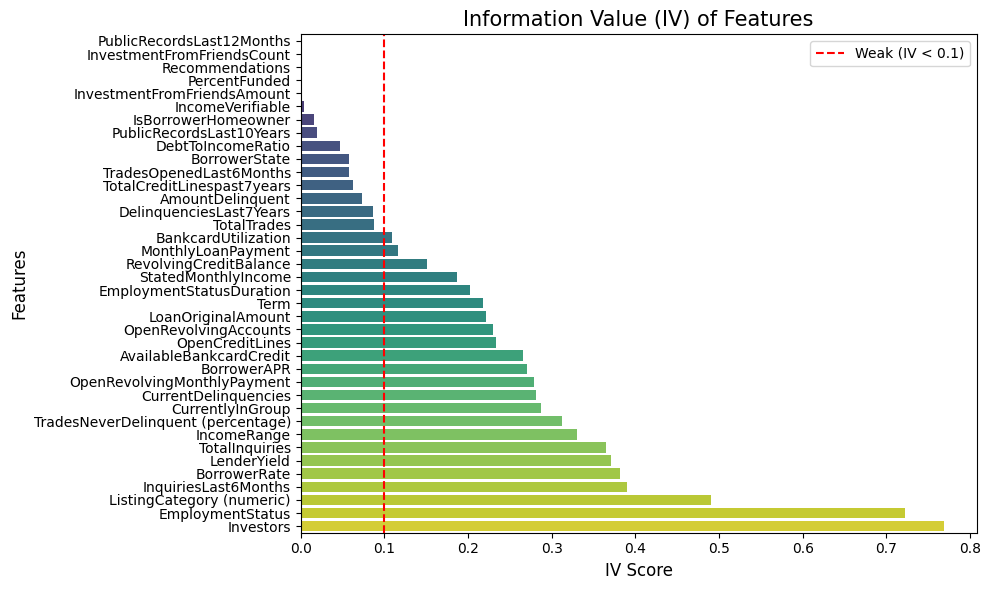

In [54]:
iv_df = pd.DataFrame.from_dict(iv_scores, orient='index', columns=['IV'])
iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=iv_df.index, data=iv_df, palette='viridis')

plt.title('Information Value (IV) of Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.02, color='red', linestyle='--', label='Not useful (IV < 0.02)')
plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (IV < 0.1)')
# plt.axvline(x=0.1, color='orange', linestyle='--', label='Weak (0.02 < IV < 0.1)')
# plt.axvline(x=0.3, color='yellow', linestyle='--', label='Medium (0.1 < IV < 0.3)')
# plt.axvline(x=0.5, color='green', linestyle='--', label='Strong (0.3 < IV < 0.5)')
# # plt.axvline(x=0.505, color='red', linestyle='--', label='Too high (0.5 < IV)')
plt.legend()

plt.tight_layout()
plt.show()

Columns with weak IV (less than 0.1) will be removed.

In [55]:
no_prediction_power = [] # to be removed
good_prediction_power = []

for key, value in iv_scores.items():
    if value <= 0.1:
        no_prediction_power += [key]
    else:
        good_prediction_power += [key]

Columns to keep:

In [56]:
print("Selected features based on IV:")
print(*good_prediction_power, sep='\n')

Selected features based on IV:
Term
BorrowerAPR
BorrowerRate
LenderYield
ListingCategory (numeric)
EmploymentStatus
EmploymentStatusDuration
CurrentlyInGroup
OpenCreditLines
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TradesNeverDelinquent (percentage)
IncomeRange
StatedMonthlyIncome
LoanOriginalAmount
MonthlyLoanPayment
Investors


### Feature selection based on Lasso CV Regression
Another method used for feature selection will be Lasso Regression. Here are the features selected by the model:

In [57]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_binned_woe)
X_test_scaled = scaler.transform(X_test_binned_woe)

lasso = LassoCV(
    alphas=np.logspace(-3, 0, 50),
    cv=5, random_state=42, max_iter=10_000)
lasso.fit(X_train_scaled, y_train)

selected_lasso = X_train_binned_woe.columns[lasso.coef_ != 0].tolist()
print("Selected features by Lasso:")
print(*selected_lasso, sep='\n')

Selected features by Lasso:
Term
BorrowerAPR
BorrowerRate
LenderYield
ListingCategory (numeric)
BorrowerState
EmploymentStatus
IsBorrowerHomeowner
CurrentlyInGroup
OpenCreditLines
TotalCreditLinespast7years
OpenRevolvingAccounts
OpenRevolvingMonthlyPayment
InquiriesLast6Months
TotalInquiries
CurrentDelinquencies
AmountDelinquent
DelinquenciesLast7Years
PublicRecordsLast10Years
RevolvingCreditBalance
BankcardUtilization
AvailableBankcardCredit
TotalTrades
TradesNeverDelinquent (percentage)
TradesOpenedLast6Months
DebtToIncomeRatio
IncomeRange
IncomeVerifiable
StatedMonthlyIncome
MonthlyLoanPayment
Investors


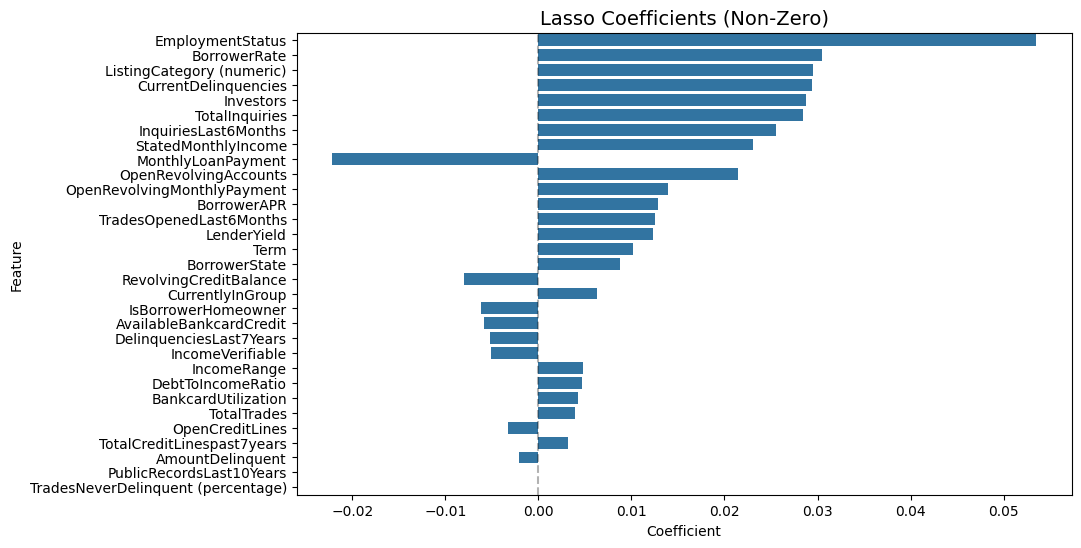

In [58]:
coef_df = pd.DataFrame({
    'Feature': X_train_binned_woe.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df[coef_df['Coefficient'] != 0])
plt.title('Lasso Coefficients (Non-Zero)', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

In [59]:
print("Optimal lambda (alpha):", lasso.alpha_)

Optimal lambda (alpha): 0.001


### Final results
After combining these two methods (Information Value and Lasso Regression) we get a list of features that will be included in the models:

In [60]:
selected_iv = good_prediction_power

final_features = list(set(selected_iv) & set(selected_lasso))
print("Final selected features (IV + Lasso):")
print(*final_features, sep='\n')
# print(*[(x, iv_scores[x]) for x in final_features], sep='\n')

Final selected features (IV + Lasso):
OpenRevolvingMonthlyPayment
EmploymentStatus
Term
TotalInquiries
IncomeRange
OpenRevolvingAccounts
CurrentlyInGroup
Investors
InquiriesLast6Months
ListingCategory (numeric)
RevolvingCreditBalance
OpenCreditLines
AvailableBankcardCredit
BorrowerRate
BorrowerAPR
LenderYield
MonthlyLoanPayment
TradesNeverDelinquent (percentage)
CurrentDelinquencies
BankcardUtilization
StatedMonthlyIncome


In [61]:
final_iv_scores = {key: iv_scores[key] for key in final_features}

Information Value for the selected features:

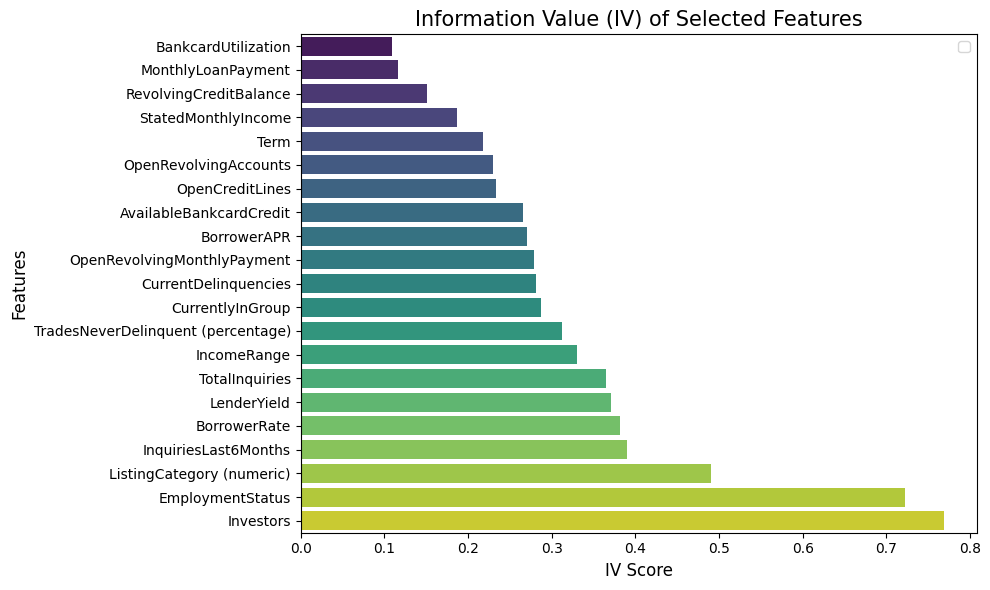

In [64]:
final_iv_df = pd.DataFrame.from_dict(final_iv_scores, orient='index', columns=['IV'])
final_iv_df.sort_values(by='IV', ascending=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='IV', y=final_iv_df.index, data=final_iv_df, palette='viridis')

plt.title('Information Value (IV) of Selected Features', fontsize=15)
plt.xlabel('IV Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
# plt.axvline(x=0.1, color='red', linestyle='--', label='Weak (0.02 < IV < 0.1)')
plt.legend()

plt.tight_layout()
plt.show()

Lasso Coefficients for the final features:

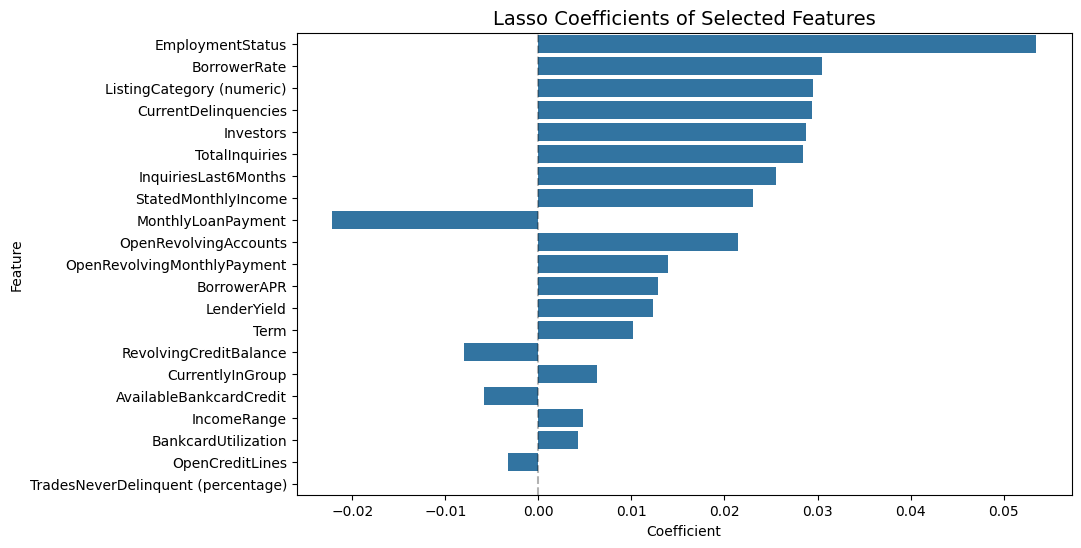

In [66]:
final_coef = coef_df[coef_df['Feature'].isin(final_features)]

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=final_coef)
plt.title('Lasso Coefficients of Selected Features', fontsize=14)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.show()

### Exporting final data

For **logistic regression** (with WOE transformation) - train and test data

In [88]:
X_train_woe = X_train_binned_woe[final_features]

X_train_woe.to_excel("X_train_woe.xlsx", index=False)

X_train_woe

,OpenRevolvingMonthlyPayment,EmploymentStatus,Term,TotalInquiries,IncomeRange,OpenRevolvingAccounts,CurrentlyInGroup,Investors,InquiriesLast6Months,ListingCategory (numeric),...,OpenCreditLines,AvailableBankcardCredit,BorrowerRate,BorrowerAPR,LenderYield,MonthlyLoanPayment,TradesNeverDelinquent (percentage),CurrentDelinquencies,BankcardUtilization,StatedMonthlyIncome
0,-0.338599,-0.858617,0.197280,1.301526,-0.477317,-0.263058,-0.241038,-2.488728,-0.430954,-0.348033,...,-0.391648,0.015906,-1.113703,-0.274813,-0.414726,-0.367320,-0.447843,-0.283922,-0.402398,-0.539908
1,-0.338599,-0.858617,0.197280,-0.421367,-0.477317,-0.263058,-0.241038,0.437904,-0.430954,-0.348033,...,-0.391648,0.015906,0.621914,0.547720,0.521011,0.139397,-0.447843,-0.283922,0.122442,-0.035691
2,0.330767,-0.858617,0.197280,-0.421367,-0.477317,0.369977,-0.241038,0.194504,-0.430954,-0.707362,...,0.013799,0.015906,-0.228562,-0.274813,-0.414726,-0.367320,0.279521,0.406309,-0.402398,-0.539908
3,1.330765,1.392762,0.197280,0.138575,1.413635,0.369977,-0.241038,0.437904,1.503662,1.349916,...,1.433036,1.419540,0.621914,0.547720,0.521011,0.450128,1.437110,1.421918,0.122442,-0.539908
4,-0.338599,-0.858617,0.197280,1.301526,-0.477317,-0.263058,-0.241038,0.437904,0.351408,-0.348033,...,-0.391648,0.015906,-0.228562,-0.274813,0.521011,0.139397,0.279521,1.421918,-0.402398,-0.539908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91839,-0.338599,-0.858617,0.197280,0.138575,0.245932,-0.263058,-0.241038,0.437904,1.503662,-0.348033,...,-0.391648,0.015906,-0.228562,-0.274813,0.521011,0.139397,-0.447843,-0.283922,0.122442,-0.035691
91840,0.330767,0.748054,0.197280,-0.421367,0.245932,-0.263058,-0.241038,0.437904,-0.430954,1.349916,...,0.013799,-0.641710,-1.113703,-1.773856,-1.657483,0.450128,-0.447843,-0.283922,-0.402398,0.564407
91841,-0.338599,-0.858617,-1.124438,-0.421367,-0.477317,-0.263058,-0.241038,-2.488728,-0.430954,-0.348033,...,-0.391648,0.015906,0.621914,0.547720,0.521011,0.139397,-0.447843,-0.283922,0.122442,-0.539908
91842,0.330767,0.748054,0.197280,-0.421367,-0.477317,0.369977,-0.241038,0.194504,-0.430954,-0.348033,...,0.013799,0.015906,-0.228562,-0.274813,-0.414726,0.139397,-0.447843,-0.283922,-0.402398,-0.035691


In [ ]:
X_test_woe = X_test_binned_woe[final_features]

X_test_woe.to_excel("X_test_woe.xlsx", index=False)

X_test_woe

,OpenRevolvingMonthlyPayment,EmploymentStatus,Term,TotalInquiries,IncomeRange,OpenRevolvingAccounts,CurrentlyInGroup,Investors,InquiriesLast6Months,ListingCategory (numeric),...,OpenCreditLines,AvailableBankcardCredit,BorrowerRate,BorrowerAPR,LenderYield,MonthlyLoanPayment,TradesNeverDelinquent (percentage),CurrentDelinquencies,BankcardUtilization,StatedMonthlyIncome
0,-0.338599,-0.858617,0.197280,-0.421367,0.245932,-0.263058,-0.241038,-2.488728,-0.430954,-0.348033,...,-0.391648,0.015906,-0.228562,-0.274813,-0.414726,0.450128,-0.447843,-0.283922,0.122442,0.564407
1,-0.338599,-0.858617,0.197280,1.301526,-0.477317,1.279645,-0.241038,0.437904,1.503662,-0.348033,...,0.013799,0.015906,0.621914,0.547720,0.521011,0.139397,-0.447843,-0.283922,0.781404,-0.539908
2,-0.338599,0.748054,0.197280,1.301526,0.245932,-0.263058,-0.241038,0.194504,0.351408,-0.348033,...,-0.391648,0.015906,0.621914,-0.274813,0.521011,-0.367320,-0.447843,-0.283922,0.122442,-0.035691
3,-0.338599,-0.858617,-1.124438,1.301526,-0.477317,0.369977,-0.241038,-2.488728,-0.430954,-0.348033,...,0.013799,-0.641710,-1.113703,-0.274813,-0.414726,-0.367320,0.279521,-0.283922,-0.402398,-0.539908
4,-0.338599,-0.858617,0.197280,-0.421367,-0.477317,-0.263058,-0.241038,0.437904,-0.430954,-0.348033,...,-0.391648,0.015906,0.621914,0.547720,0.521011,0.139397,0.279521,-0.283922,0.122442,-0.539908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22956,0.330767,-0.858617,0.197280,-0.421367,0.245932,0.369977,-0.241038,0.437904,-0.430954,-0.348033,...,0.013799,0.015906,0.621914,0.547720,0.521011,0.139397,-0.447843,-0.283922,0.122442,0.564407
22957,-0.338599,0.748054,-1.124438,0.138575,-0.477317,-0.263058,-0.241038,0.194504,-0.430954,-0.707362,...,-0.391648,-0.641710,-0.228562,-0.274813,-0.414726,-0.367320,-0.447843,-0.283922,-0.402398,-0.539908
22958,-0.338599,0.748054,0.197280,0.138575,1.413635,-0.263058,1.222028,0.194504,0.351408,1.349916,...,1.433036,1.419540,-0.228562,-0.274813,-0.414726,0.450128,1.437110,-0.283922,0.122442,0.564407
22959,-0.338599,-0.858617,0.197280,-0.421367,-0.477317,-0.263058,-0.241038,-2.488728,-0.430954,-0.348033,...,-0.391648,-0.641710,-1.113703,-0.274813,-1.657483,0.139397,-0.447843,-0.283922,-0.402398,-0.539908


For other models: **random forest**, **xgboost** and **neural network** (prepared data, with no WOE transformations) - train and test data

In [ ]:
X_train_standard = X_train[final_features]

X_train_standard.to_excel("X_train_standard.xlsx", index=False)

X_train_standard

,OpenRevolvingMonthlyPayment,EmploymentStatus,Term,TotalInquiries,IncomeRange,OpenRevolvingAccounts,CurrentlyInGroup,Investors,InquiriesLast6Months,ListingCategory (numeric),...,OpenCreditLines,AvailableBankcardCredit,BorrowerRate,BorrowerAPR,LenderYield,MonthlyLoanPayment,TradesNeverDelinquent (percentage),CurrentDelinquencies,BankcardUtilization,StatedMonthlyIncome
277,179.0,Employed,36,12.0,"$75,000-99,999",7,0,1,0.0,7,...,18.000000,5233.000000,0.1274,0.16324,0.1174,302.12,1.000000,0.0,0.550000,7000.000000
35982,832.0,Employed,36,1.0,"$50,000-74,999",10,0,17,1.0,1,...,12.000000,4444.000000,0.3177,0.35797,0.3077,173.71,1.000000,0.0,0.800000,5333.333333
78390,35.0,Employed,36,4.0,"$75,000-99,999",3,0,172,0.0,19,...,2.000000,3642.000000,0.1679,0.20462,0.1579,533.22,0.640000,1.0,0.190000,6416.666667
9201,24.0,Not available,36,11.0,Not displayed,2,0,11,5.0,0,...,9.286626,11220.777015,0.2875,0.30709,0.2825,41.77,0.886642,8.0,0.561801,16666.666667
44010,419.0,Employed,36,14.0,"$75,000-99,999",15,0,49,2.0,1,...,16.000000,1139.000000,0.2100,0.24807,0.2000,150.70,0.780000,6.0,0.400000,6500.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,181.0,Employed,36,7.0,"$25,000-49,999",6,0,41,5.0,1,...,11.000000,1418.000000,0.2099,0.24758,0.1999,188.35,0.920000,0.0,0.700000,3750.000000
73542,40.0,Full-time,36,1.0,"$1-24,999",4,0,21,0.0,0,...,5.000000,20320.000000,0.0715,0.08290,0.0665,46.42,1.000000,0.0,0.010000,1666.666667
83281,1795.0,Employed,60,3.0,"$75,000-99,999",17,0,1,1.0,1,...,19.000000,4813.000000,0.2474,0.27308,0.2374,204.39,0.910000,0.0,0.960000,6333.333333
83467,81.0,Self-employed,36,3.0,"$50,000-74,999",3,0,125,0.0,3,...,4.000000,6829.000000,0.1505,0.17221,0.1405,138.76,1.000000,0.0,0.020000,4166.666667


In [ ]:
X_test_standard = X_test[final_features]

X_test_standard.to_excel("X_test_standard.xlsx", index=False)

X_test_standard

,OpenRevolvingMonthlyPayment,EmploymentStatus,Term,TotalInquiries,IncomeRange,OpenRevolvingAccounts,CurrentlyInGroup,Investors,InquiriesLast6Months,ListingCategory (numeric),...,OpenCreditLines,AvailableBankcardCredit,BorrowerRate,BorrowerAPR,LenderYield,MonthlyLoanPayment,TradesNeverDelinquent (percentage),CurrentDelinquencies,BankcardUtilization,StatedMonthlyIncome
104644,507.0,Employed,36,5.0,"$25,000-49,999",10,0,1,0.0,1,...,11.000000,3439.000000,0.1585,0.19501,0.1485,105.25,1.000000,0.0,0.840000,2333.333333
51793,246.0,Employed,36,12.0,"$75,000-99,999",1,0,21,5.0,2,...,2.000000,0.000000,0.3199,0.35643,0.3099,174.20,0.920000,0.0,0.000000,7916.666667
81387,142.0,Full-time,36,13.0,"$25,000-49,999",9,0,102,3.0,1,...,12.000000,2356.000000,0.2332,0.24830,0.2232,252.70,0.940000,0.0,0.630000,3950.000000
31356,572.0,Employed,60,13.0,"$100,000+",3,0,1,1.0,1,...,8.000000,17222.000000,0.1274,0.15016,0.1174,339.30,0.840000,0.0,0.360000,10833.333333
915,329.0,Employed,36,1.0,"$75,000-99,999",6,0,54,1.0,1,...,10.000000,3252.000000,0.2492,0.28780,0.2392,198.59,0.780000,0.0,0.690000,6666.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113482,77.0,Employed,36,1.0,"$25,000-49,999",3,0,54,0.0,1,...,4.000000,59.000000,0.2492,0.28780,0.2392,218.45,1.000000,0.0,0.980000,2121.750000
86124,575.0,Self-employed,60,7.0,"$50,000-74,999",14,0,182,1.0,15,...,14.000000,27258.000000,0.1940,0.21832,0.1840,392.42,1.000000,0.0,0.460000,6000.000000
38229,502.0,Full-time,36,6.0,Not displayed,9,1,94,3.0,0,...,9.286626,11220.777015,0.1687,0.17591,0.1537,106.76,0.886642,0.0,0.561801,3000.000000
46742,395.0,Employed,36,5.0,"$100,000+",9,0,1,0.0,1,...,12.000000,20327.000000,0.0879,0.11563,0.0779,158.51,1.000000,0.0,0.520000,12500.000000


Target variable

In [ ]:
y_train.to_excel("y_train.xlsx", index=False)

y_train

277      0
35982    0
78390    0
9201     0
44010    0
        ..
5695     0
73542    0
83281    0
83467    0
45919    0
Name: Defaulted, Length: 91844, dtype: int64

In [ ]:
y_test = test_df["Defaulted"]

y_test.to_excel("y_test.xlsx", index=False)

y_test

104644    0
51793     1
81387     0
31356     0
915       0
         ..
113482    0
86124     0
38229     0
46742     0
31185     0
Name: Defaulted, Length: 22961, dtype: int64